In [11]:
#Importing all relevant libraries
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.layers import LSTM
from operator import itemgetter
import collections

In [12]:
meta_movie = pd.read_csv("D:/Ed/Plaksha/4th Semester/Data Mining/MovieSummaries/movie.metadata.tsv", sep = '\t', header=None)
meta_movie.rename(columns={0: 'movie ID',1: 'freebase ID', 2: 'Movie Name', 3:'Release Date', 4: 'Revenue', 5: 'Runtime(minutes)', 6: 'languages', 7: 'countries' ,8: 'genres'}, inplace=True)
meta_movie['movie ID'] = meta_movie['movie ID'].astype(str)
meta_movie = meta_movie.dropna(subset=['Release Date'])
meta_movie['Release Date'] = pd.to_datetime(meta_movie['Release Date'].astype(str).str[:4], errors='ignore').astype(int)
meta_movie.head()

,movie ID,freebase ID,Movie Name,Release Date,Revenue,Runtime(minutes),languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [13]:
meta_char = pd.read_csv("D:/Ed/Plaksha/4th Semester/Data Mining/MovieSummaries/character.metadata.tsv", sep = '\t', header=None)
meta_char.rename(columns={0: 'Wikipedia movie ID',1: 'freebase ID', 2: 'Movie Release Date',3: 'Character Name',4: 'DOB', 5: 'Gender', 6: 'Height(m)', 7: 'Actor Ethnicity' ,8: 'Actor Name', 9: 'Age', 10: 'Freebase Character Map'}, inplace=True)
meta_char = meta_char.set_index('Wikipedia movie ID')
meta_char.reset_index()
meta_char = meta_char.dropna(subset=['Movie Release Date'])
meta_char['Movie Release Date'] = pd.to_datetime(meta_char['Movie Release Date'].astype(str).str[:4], errors='ignore').astype(int)
meta_char = meta_char.dropna(subset=['Actor Ethnicity'])
meta_char['Age'] = meta_char['Age'].abs()
meta_char.head()

,freebase ID,Movie Release Date,Character Name,DOB,Gender,Height(m),Actor Ethnicity,Actor Name,Age,Freebase Character Map,11,12
Wikipedia movie ID,,,,,,,,,,,,
975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
975900,/m/03vyhn,2001,Tres,1959-03-09,M,NaN,/m/064b9n,Rodney A. Grant,42.0,/m/0bgchrs,/m/0bgchrw,/m/03ydsb
3196793,/m/08yl5d,2000,NaN,1937-11-10,M,NaN,/m/0x67,Albert Hall,62.0,/m/0lr37dy,NaN,/m/01lntp


In [14]:
movies = pd.read_csv("D:/Ed/Plaksha/4th Semester/Data Mining/MovieSummaries/plot_summaries.txt", sep='\t', header=None, names=['movie ID', 'plot'])
movies['movie ID'] = movies['movie ID'].astype(str)
#movies = movies.set_index('movie ID')
#movies.reset_index()
movies = pd.merge(movies, meta_movie[['movie ID', 'Movie Name', 'genres']], on = 'movie ID')
movies.head()

,movie ID,plot,Movie Name,genres
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [15]:
oscars = pd.read_csv("D:/Ed/Plaksha/4th Semester/Data Mining/MovieSummaries/the_oscar_award.csv")
actOscars = oscars[(oscars['category'] == 'ACTOR') | (oscars['category'] == 'ACTRESS')]
winners = actOscars[actOscars['winner'] == True]
winners = winners.drop(columns=['winner'])
winners.head()

,year_film,year_ceremony,ceremony,category,name,film
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven
36,1928,1929,2,ACTOR,Warner Baxter,In Old Arizona
45,1928,1929,2,ACTRESS,Mary Pickford,Coquette
73,1929,1930,3,ACTOR,George Arliss,Disraeli


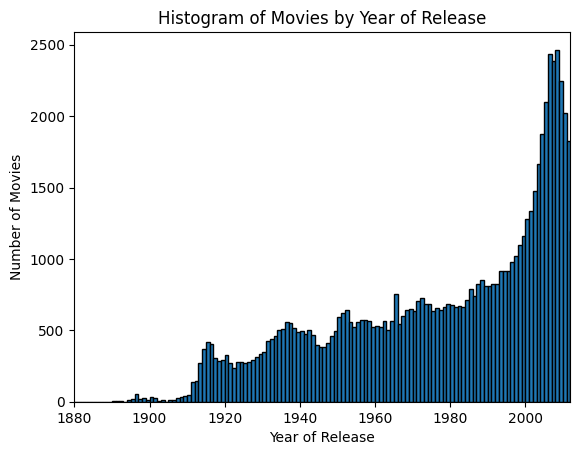

In [16]:
#Plotting a histtogram of the number of movoie releases over the years starting from the 1880s.
meta_movie['Release Date'].hist(bins=range(meta_movie['Release Date'].min(), meta_movie['Release Date'].max() + 1), edgecolor='black')
plt.xlabel('Year of Release')
plt.ylabel('Number of Movies')
plt.title('Histogram of Movies by Year of Release')
plt.xlim([1880,2012])
plt.grid(False)
plt.show()

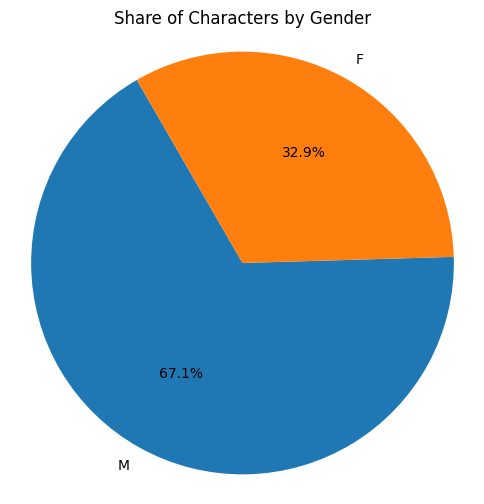

In [17]:
#Creating a piechart of the distirbution of characters by gender
genderCounts = meta_char['Gender'].value_counts()

plt.figure(figsize=(6, 6))
colorss = ['#1f77b4', '#ff7f0e']
plt.pie(genderCounts, labels=genderCounts.index, autopct='%1.1f%%', colors=colorss, startangle=120)
plt.title('Share of Characters by Gender')
plt.axis('equal')
plt.show()


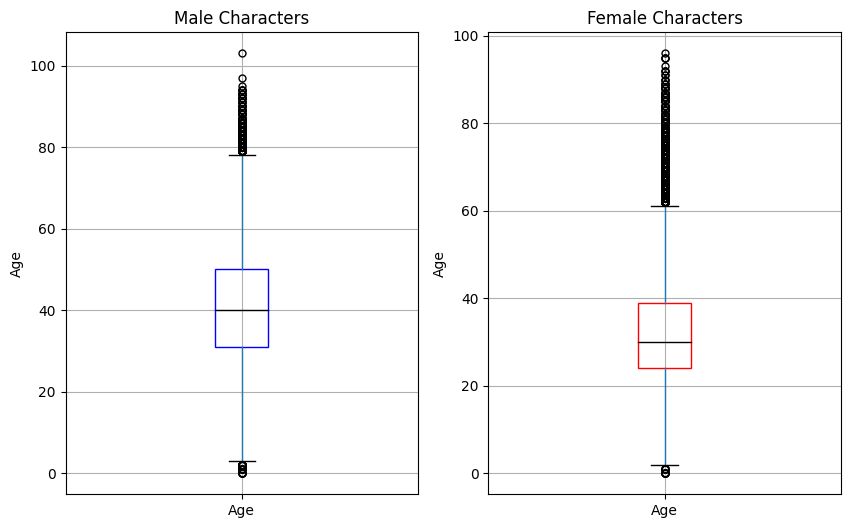

In [18]:
#Boxplots of both genders by age to understand the distributions of character ages and comparing by gender
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
meta_char[meta_char['Gender'] == 'M'].boxplot(column='Age', patch_artist=True, flierprops=dict(marker='o', markersize=5, markerfacecolor='none', linestyle='none'), boxprops=dict(facecolor='none', color='blue'), medianprops=dict(color='black'))
plt.title('Male Characters')
plt.ylabel('Age')

plt.subplot(1, 2, 2)
meta_char[meta_char['Gender'] == 'F'].boxplot(column='Age', patch_artist=True, flierprops=dict(marker='o', markersize=5, markerfacecolor='none', linestyle='none'), boxprops=dict(facecolor='none', color='red'), medianprops=dict(color='black'))
plt.title('Female Characters')
plt.ylabel('Age')

plt.grid(True)
plt.show()

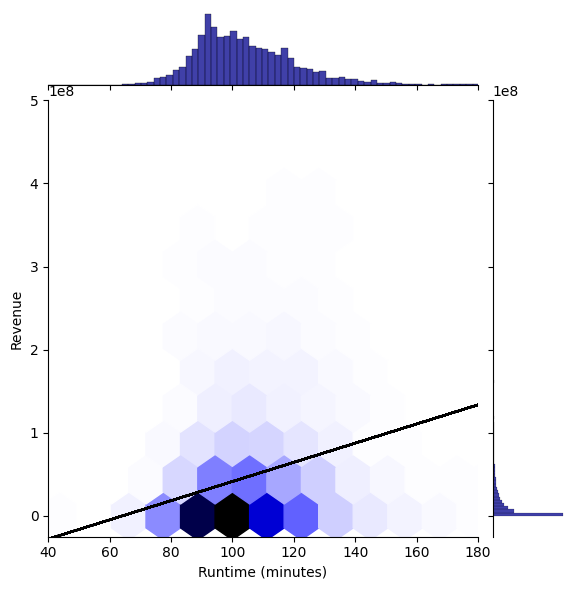

Revenue added per minute of film: 1153280.0579921396


In [19]:
#A hex plot of the movie runtime vs the revenue generated 
meta_movie_clean = meta_movie.dropna(subset=['Revenue', 'Runtime(minutes)'])

filtered_meta_movie = meta_movie_clean[(meta_movie_clean['Runtime(minutes)'] < 300) & 
                                       (meta_movie_clean['Revenue'] < 1200000000) & 
                                       (meta_movie_clean['Revenue'] != 0)]

X = sm.add_constant(filtered_meta_movie['Runtime(minutes)'])
model = sm.OLS(filtered_meta_movie['Revenue'], X)
results = model.fit()
predictions = results.predict(X)
residuals = filtered_meta_movie['Revenue'] - predictions

sns.jointplot(x=filtered_meta_movie['Runtime(minutes)'], y=filtered_meta_movie['Revenue'], kind="hex", color="darkblue", gridsize=24)
plt.xlabel('Runtime (minutes)')
plt.ylabel('Revenue')
plt.title('Hexagonal Bin Plot of Revenue vs Movie Runtime')
plt.xlim(40, 180)
plt.ylim(-25000000, 500000000)
plt.plot(filtered_meta_movie['Runtime(minutes)'], results.predict(), color='black')
plt.show()

print("Revenue added per minute of film:", results.params['Runtime(minutes)'])


Mean of residuals: -1.8720579332698307e-08


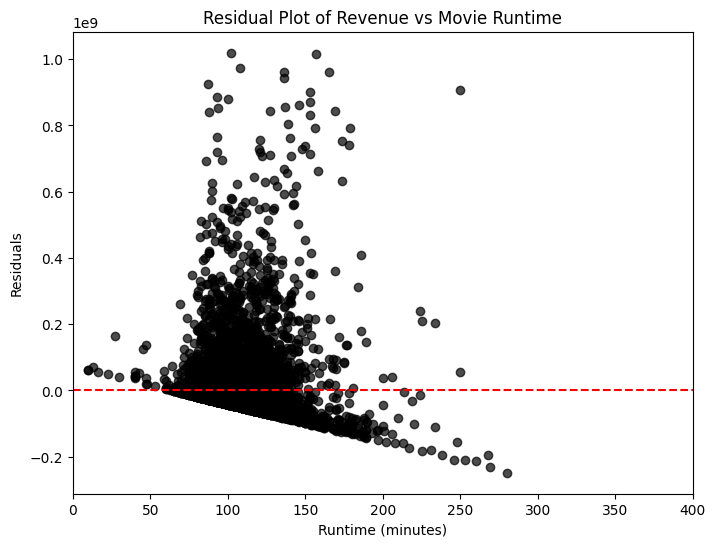

In [20]:
#Plotting residuals of the above regression
meanResiduals = np.mean(residuals)
print("Mean of residuals:", meanResiduals)

plt.figure(figsize=(8, 6))
plt.scatter(filtered_meta_movie['Runtime(minutes)'], residuals, color='black', alpha=0.7, marker='o', edgecolor='black')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Residuals')
plt.title('Residual Plot of Revenue vs Movie Runtime')
plt.xlim(0, 400)
plt.show()

In [22]:
#Using spacy for sentiment analysis of all plot summaries
nlp = spacy.load('en_core_web_sm')

plot_docs = []
for plot_summary in movies['plot']:
    doc = nlp(plot_summary)
    plot_docs.append(doc)
    if len(plot_docs)%1000==0:
        print(f'Summaries processed: {len(plot_docs)}')

Summaries processed: 1000
Summaries processed: 2000
Summaries processed: 3000
Summaries processed: 4000
Summaries processed: 5000
Summaries processed: 6000
Summaries processed: 7000
Summaries processed: 8000
Summaries processed: 9000
Summaries processed: 10000
Summaries processed: 11000
Summaries processed: 12000
Summaries processed: 13000
Summaries processed: 14000
Summaries processed: 15000
Summaries processed: 16000
Summaries processed: 17000
Summaries processed: 18000
Summaries processed: 19000
Summaries processed: 20000
Summaries processed: 21000
Summaries processed: 22000
Summaries processed: 23000
Summaries processed: 24000
Summaries processed: 25000
Summaries processed: 26000
Summaries processed: 27000
Summaries processed: 28000
Summaries processed: 29000
Summaries processed: 30000
Summaries processed: 31000
Summaries processed: 32000
Summaries processed: 33000
Summaries processed: 34000
Summaries processed: 35000
Summaries processed: 36000
Summaries processed: 37000
Summaries 

In [23]:
#Using nltk to calculate compound sentiment of the plots
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

sentiment_scores = []
for doc in plot_docs:
    sentiment_score = sid.polarity_scores(doc.text)
    sentiment_scores.append(sentiment_score['compound'])

sentiments = pd.DataFrame({'movie ID': movies['movie ID'], 'sentiment_score': sentiment_scores})

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


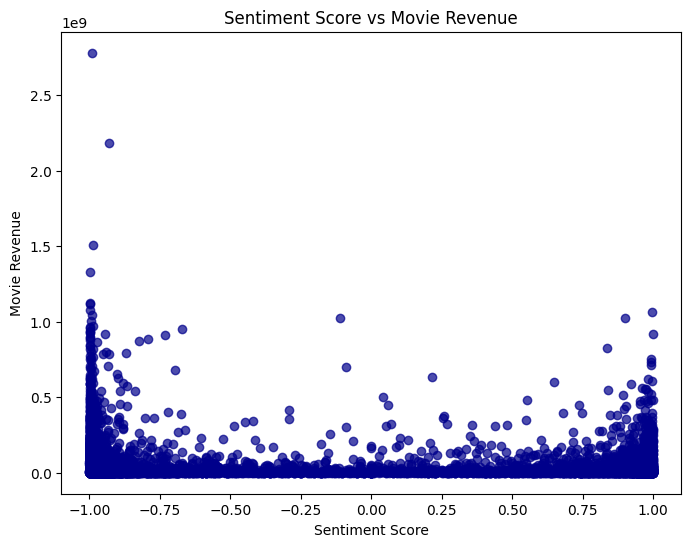

In [24]:
# Plotting sentiment scores against movie revenue
merged_data = pd.merge(sentiments, meta_movie, on='movie ID')

plt.figure(figsize=(8, 6))
plt.scatter(merged_data['sentiment_score'], merged_data['Revenue'], color='darkblue', alpha=0.7)
plt.xlabel('Sentiment Score')
plt.ylabel('Movie Revenue')
plt.title('Sentiment Score vs Movie Revenue')
plt.show()

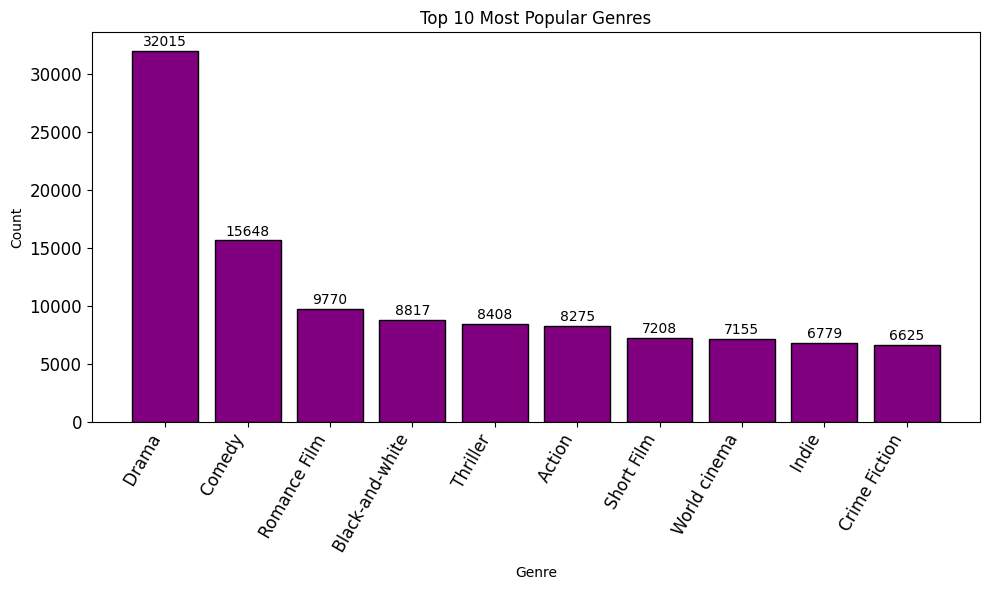

In [25]:
#Plotting top 10 genres with most movie releases
delimiters = r'[:,]'
genre_maps = {}
for genres in meta_movie['genres']:
    genres = genres[1:-1]
    genres = genres.replace("\"", "")
    all = re.split(delimiters, genres)
    inter = {}
    for i in range(1, len(all), 2):
        key = all[i-1]
        value = all[i]
        inter[key] = value 
    for key, value in inter.items():
        if key not in genre_maps:
            genre_maps[key] = value

genre_counts = {}
for genres in meta_movie['genres']:
    for genre in eval(genres):
        genre_name = genre.split(':')[-1].strip().strip('}').strip('"')
        if genre_name in genre_counts:
            genre_counts[genre_name] += 1
        else:
            genre_counts[genre_name] = 1

filtered_genre_counts = {genre: count for genre, count in genre_counts.items() if count >= 0}

sorted_genre_counts = sorted(filtered_genre_counts.items(), key=lambda x: x[1], reverse=True)
mapped_tuples = []
for key, count in sorted_genre_counts:
    if key in genre_maps:
        mapped_tuples.append((genre_maps[key], count))

mapped_tuples.sort(key=lambda x: x[1], reverse=True)
top_10_mapped_tuples = mapped_tuples[:10]
genres, counts = zip(*top_10_mapped_tuples)

plt.figure(figsize=(10, 6))
bars = plt.bar(genres, counts, color='#800080', edgecolor='black')  # Using Hex color for darker purple

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 420, bar.get_height(), ha='center', color='black')

plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Top 10 Most Popular Genres')
plt.xticks(rotation=60, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

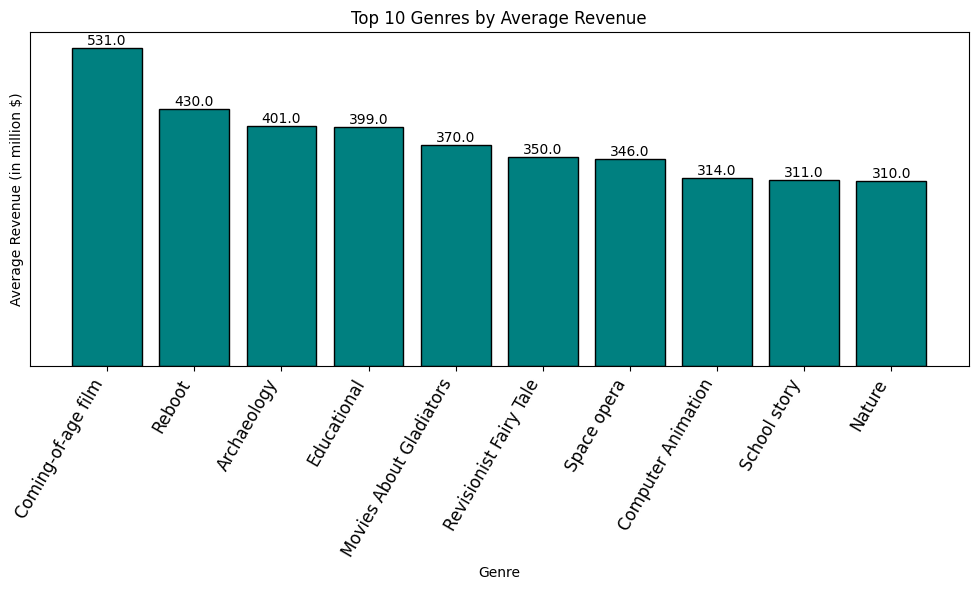

In [26]:
#Calculating the average revenue that movies from specific genre yield, showing top 10 genres.
genre_revenue = {}
genre_count = {}
for _, row in meta_movie.iterrows():
    genres = eval(row['genres'])
    revenue = row['Revenue']
    if not pd.isna(revenue):
        for id, genre in genres.items():
            genre_name = genre
            if genre_name in genre_revenue:
                genre_revenue[genre_name] += revenue
                genre_count[genre_name] += 1
            else:
                genre_revenue[genre_name] = revenue
                genre_count[genre_name] = 1

genre_avg_revenue = {genre: revenue / count for genre, revenue, count in zip(genre_revenue.keys(), genre_revenue.values(), genre_count.values())}
sorted_genre_avg_revenue = sorted(genre_avg_revenue.items(), key=lambda x: x[1], reverse=True)

top_10_genres = [genre for genre, _ in sorted_genre_avg_revenue[:10]]
top_10_avg_revenue = [avg_revenue for _, avg_revenue in sorted_genre_avg_revenue[:10]]

plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_genres, top_10_avg_revenue, color='#008080', edgecolor='black')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5e6, int(bar.get_height())//1e6, ha='center', color='black')

plt.xlabel('Genre')
plt.ylabel('Average Revenue (in million $)')
plt.title('Top 10 Genres by Average Revenue')
plt.xticks(rotation=60, ha='right', fontsize=12)
plt.yticks([])
plt.tight_layout()
plt.show()

In [27]:
#transforming the genres column to remove the freebase ID of the genres
allGenres=[]
for entry in movies['genres']:
    entry = entry[1:-1]
    genres = entry.replace("\"", "")
    genres = genres.replace(" ", "")
    genres = re.split(delimiters, genres)
    genres = genres[1::2]
    allGenres.append(genres)
movies['genres'] = allGenres
movies['spaCyPlot'] = plot_docs

In [43]:
#Creating a graph where all actors are nodes and edges connect two actors when they have worked together on a movie
G = nx.Graph()
actor_movies = {}

for index, row in meta_char.iterrows():
    actor_name = row['Actor Name']
    movie_id = row['freebase ID']

    if actor_name not in actor_movies:
        actor_movies[actor_name] = set()

    actor_movies[actor_name].add(movie_id)

for actor, movies in actor_movies.items():
    other_actors = set()
    for movie in movies:
        other_actors.update(meta_char[meta_char['freebase ID'] == movie]['Actor Name'].drop_duplicates().tolist())

    other_actors.remove(actor)
    for other_actor in other_actors:
        if G.has_edge(actor, other_actor):
            G[actor][other_actor]['weight'] += 1
        else:
            G.add_edge(actor, other_actor, weight=1)


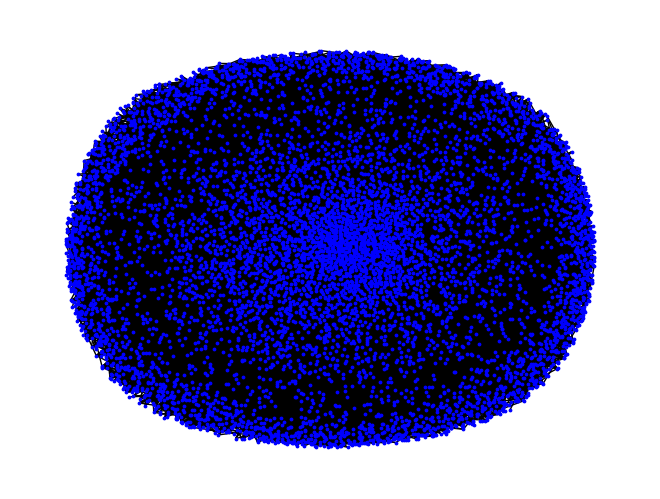

In [30]:
#An attempt at visualising the network of actors, but too dense to draw conclusions
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=False, node_color='blue', node_size=3, edge_color='black')

In [31]:
# Printing nodes and edges of our graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 7626
Number of edges: 157879


In [32]:
#To measure the versatility of an actor, we find the node with highest degree.
node_degrees = dict(G.degree())

# Sort in descending order and get top 10
top_10_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)[:10]

print("Top 10 Actors by versatility")
for node in top_10_nodes:
    print("Actor name:", node, "\t\t# actors worked with:", node_degrees[node])


Top 10 Actors by versatility
Actor name: Samuel L. Jackson 		# actors worked with: 509
Actor name: Anupam Kher 		# actors worked with: 450
Actor name: Amitabh Bachchan 		# actors worked with: 372
Actor name: Whoopi Goldberg 		# actors worked with: 369
Actor name: Robert De Niro 		# actors worked with: 364
Actor name: Steve Buscemi 		# actors worked with: 354
Actor name: Keith David 		# actors worked with: 349
Actor name: John Goodman 		# actors worked with: 338
Actor name: Paresh Rawal 		# actors worked with: 330
Actor name: Christopher Walken 		# actors worked with: 329


In [ ]:
#Calculating betweenness centrality
betweenness = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

In [40]:
#Top 10 actors by betweenness centrality
for actor, i in sorted_betweenness[:10]:
    print(actor, 'has betweeness:', i)

Anupam Kher has betweeness: 0.026973491850860565
Amrish Puri has betweeness: 0.012515111443165056
Ron Jeremy has betweeness: 0.012292365829665034
Ben Kingsley has betweeness: 0.012051570184735775
Samuel L. Jackson has betweeness: 0.011482158724960608
Irrfan Khan has betweeness: 0.011197851962216895
Naseeruddin Shah has betweeness: 0.010711666700862892
James Earl Jones has betweeness: 0.009952236641875858
Gulshan Grover has betweeness: 0.009602657294406212
Aishwarya Rai has betweeness: 0.009534410442781683


In [36]:
#Calculating degrees
degrees = dict(G.degree(G.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

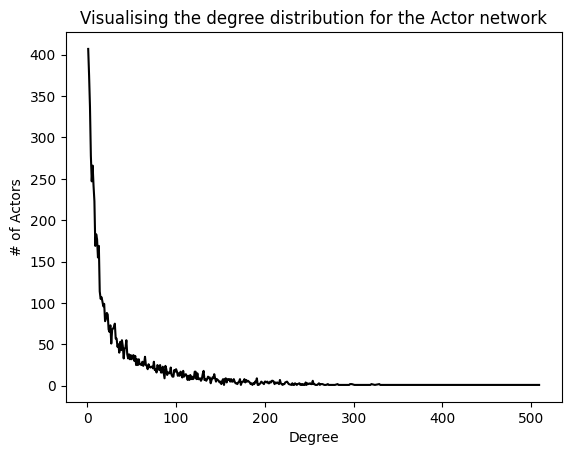

In [39]:
#Plotting degrees by #of actors
degree_seq = [d[1] for d in sorted_degree]
degreeCount = collections.Counter(degree_seq)
degreeCount = pd.DataFrame.from_dict( degreeCount, orient='index').reset_index()
fig = plt.figure()
ax = plt.gca()
ax.plot(degreeCount['index'], degreeCount[0], '-', c='black', markersize= 8)
plt.ylabel('# of Actors')
plt.xlabel('Degree')
plt.title('Visualising the degree distribution for the Actor network')
plt.show()

In [47]:
#Adding a column to the meta_char dataframe indicating whether that role won the actor/actress an Oscar
movies_with_oscar = pd.merge(winners[['film']], meta_movie, how='inner', left_on='film', right_on='Movie Name')
meta_char['Won_Oscar'] = meta_char['freebase ID'].isin(movies_with_oscar['freebase ID']).astype(int)
oscar_winners_df = meta_char[meta_char['Won_Oscar'] == True]

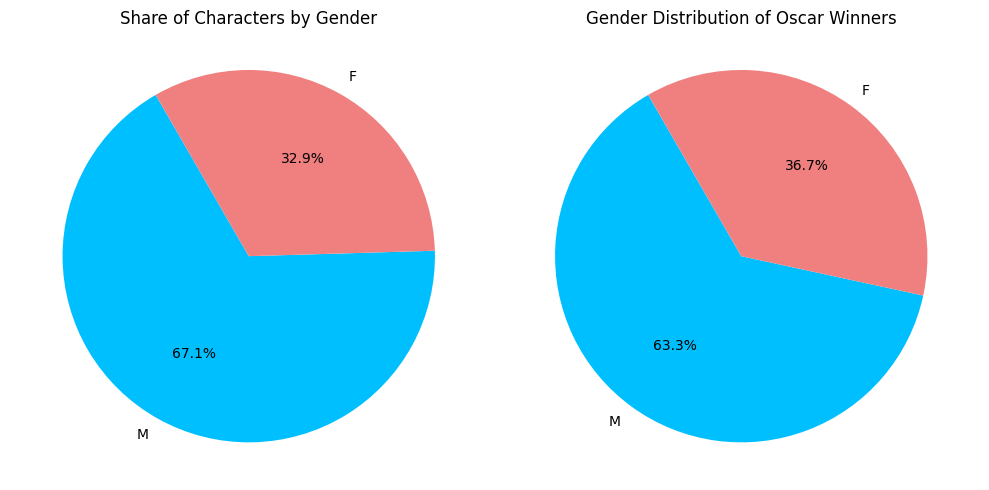

In [50]:
# Plot the gender distribution of oscar winners as a pie chart
genderCounts = meta_char['Gender'].value_counts()
gender_counts = oscar_winners_df['Gender'].value_counts()
colors_oscars = ['deepskyblue', 'lightcoral']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pie(genderCounts, labels=genderCounts.index, autopct='%1.1f%%', colors=colors_oscars, startangle=120)
plt.title('Share of Characters by Gender')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.pie(gender_counts, labels=gender_counts.index, colors=colors_oscars, autopct='%1.1f%%', startangle=120)
plt.title('Gender Distribution of Oscar Winners')
plt.axis('equal')

plt.tight_layout()
plt.show()


In [102]:
#Implementing a chi-square test to check if gender bias plays a role in the Oscars.
#Null Hypothesis H0: There is no gender bias in the Oscar awards.
#Alternate Hypothesis H1: There is an gender bias in the Oscar awards.
import pandas as pd
from scipy.stats import chi2_contingency

gender_and_oscars = meta_char[['Gender', 'Won_Oscar']]

contingency_table = pd.crosstab(gender_and_oscars['Gender'], gender_and_oscars['Won_Oscar'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Interpret results
alpha = 0.05
print("Chi-square statistic:", chi2)
print("P-value:", p_value)
if p_value < alpha:
    print("There is significant evidence to reject the null hypothesis, indicating a possible gender bias in Oscar awards.")
else:
    print("There is no significant evidence to reject the null hypothesis, suggesting no gender bias in Oscar awards.")


Chi-square statistic: 1.6887729080027762
P-value: 0.1937628059033628
There is no significant evidence to reject the null hypothesis, suggesting no gender bias in Oscar awards.


In [ ]:
#Implementing a chi-square test to check if ethnicity bias plays a role in the Oscars.
#Null Hypothesis H0: There is no ethnicity bias in the Oscar awards.
#Alternate Hypothesis H1: There is an ethnicity bias in the Oscar awards.
ethnicity_and_oscars = meta_char[['Actor Ethnicity', 'Won_Oscar']]

contingency_table_ethnicity = pd.crosstab(ethnicity_and_oscars['Actor Ethnicity'], ethnicity_and_oscars['Won_Oscar'])
chi2, p_value, _, _ = chi2_contingency(contingency_table_ethnicity)

alpha = 0.05
print("Chi-square statistic:", chi2)
print("p-value:", p_value)
if p_value < alpha:
    print("There is significant evidence to reject the null hypothesis, indicating a possible ethnicity bias in Oscar awards.")
else:
    print("There is no significant evidence to reject the null hypothesis, suggesting no ethnicity bias in Oscar awards.")


Chi-square statistic: 424.58466211325265
P-value: 0.9562428913101307
There is no significant evidence to reject the null hypothesis, suggesting no ethnicity bias in Oscar awards.


In [104]:
#Implementing Logistic Regression to check if there is an age bias in the Oscars.
age_and_oscars = meta_char[['Age', 'Won_Oscar']].dropna()
X = age_and_oscars['Age']
y = age_and_oscars['Won_Oscar']

X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.017832
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:              Won_Oscar   No. Observations:                93341
Model:                          Logit   Df Residuals:                    93339
Method:                           MLE   Df Model:                            1
Date:                Fri, 10 May 2024   Pseudo R-squ.:               0.0002976
Time:                        15:01:32   Log-Likelihood:                -1664.4
converged:                       True   LL-Null:                       -1664.9
Covariance Type:            nonrobust   LLR p-value:                    0.3195
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.7883      0.188    -30.791      0.000      -6.157      -5.420
Age           -0.0047      0